In [76]:
import sys
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# Add project root to path to allow importing src
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))

from src.monotone_grad_nets.models.mmgn import M_MGN
from src.monotone_grad_nets.trainers import trainer
from src.monotone_grad_nets.utils.plotting import plot_model_test, find_gm_components


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset:

In [ ]:
# Example usage
input_image_path = './data/daylight_image.png' # Set correct Path to source image
input_image = Image.open(input_image_path)

target_image_path = './data/sunset_image.jpeg' # Set correct Path to target image
target_image = Image.open(target_image_path)

transform = transforms.Compose([
    transforms.ToTensor(),
])

input_tensor = transform(input_image)
target_tensor = transform(target_image)

## Target Distribution:

We model our target distribution as a multivariate Gaussian with mean (the empirical mean of the target data) and covariance matrix (the empirical covariance matrix of the target data).

In [3]:
# Convert the image to a NumPy array
all_channels = target_tensor.permute(1, 2, 0).view(-1, 3).numpy()

gmm_target = GaussianMixture(n_components=1).fit(all_channels)

target_distribution = {
    'mean': torch.tensor(gmm_target.means_)[0].to(device),
    'cov': torch.tensor(gmm_target.covariances_)[0].to(device),
    }

# Color Transport using MMGN:

In [68]:
# Create dataset and DataLoader
input_data = input_tensor.permute(1, 2, 0).view(-1, 3)
dataset = TensorDataset(input_data)
train_loader = DataLoader(dataset, batch_size=len(dataset) // 4, shuffle=True)

# Define Model
model_MMGN = M_MGN(input_dim=3, hidden_dim=2, num_layers=2).to(device)

print('Model Number of Parameters: ', sum(p.numel() for p in model_MMGN.parameters()))

Model Number of Parameters:  28


In [69]:
mmgn_trainer = trainer.Trainer(
    task='optimal_transport',
    target_distribution=target_distribution,
    model=model_MMGN,
    input_data=input_tensor.to(device),
    target_data=target_tensor.to(device),
    criterion='kld',
    device=device,
    n_epochs=50,
    weight_decay=0.05,
    use_amp=False, #True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    grad_clip_max_norm=1.0,

)

# Train the model
mmgn_trainer.train(train_loader)

Epoch 50 | Train Loss: 0.0290 | Train Cost: 0.1821 | : 100%|██████████| 50/50 [12:19<00:00, 14.78s/it]


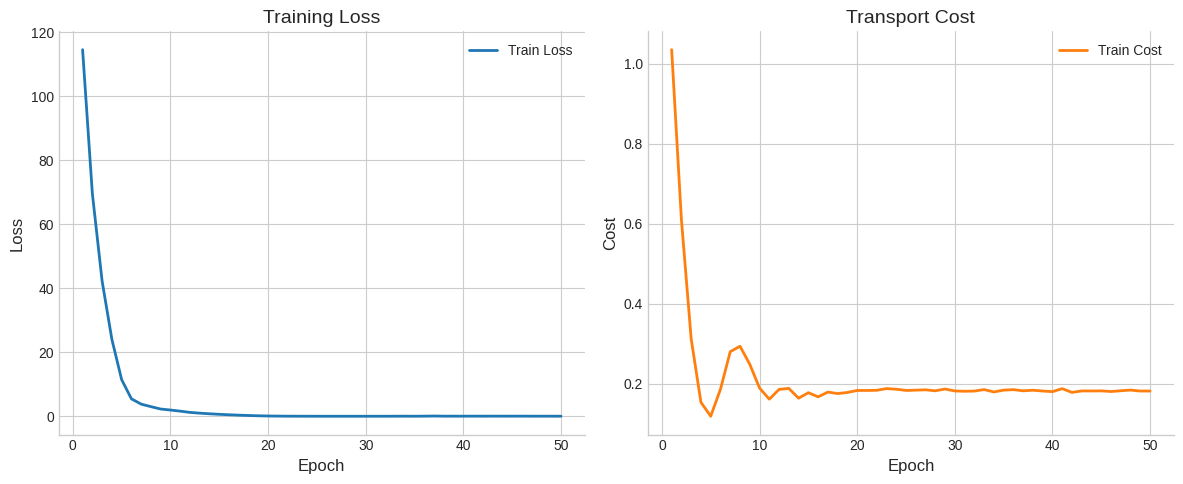

In [70]:
mmgn_trainer.plot_train_metrics(plot_cost=True)

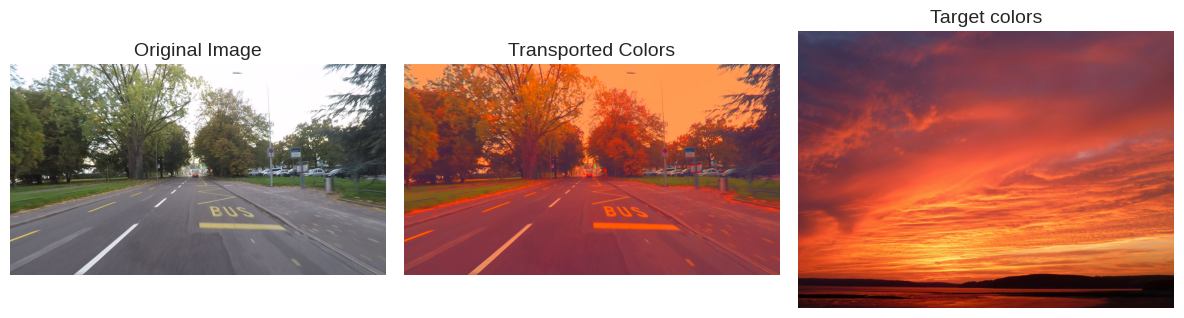

In [ ]:
mmgn_trainer.model.eval()
plot_model_test(mmgn_trainer.model.to("cpu"), "./data/daylight_image.png", target_tensor, save_path="./output/01_mmgn_output.png")

**Test on Unseen Image**

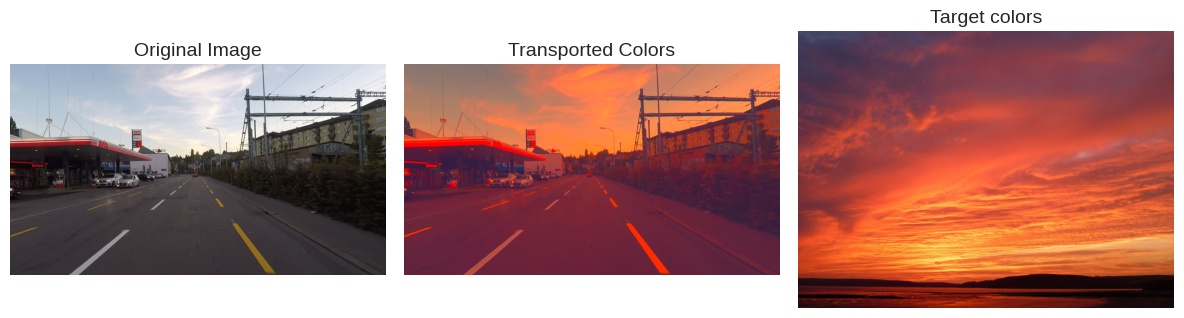

In [ ]:
plot_model_test(mmgn_trainer.model.to("cpu"), "./data/street_test_image.png", target_tensor,  save_path="./output/02_mmgn_output.png")